# <center>________________________________________________________________</center>

# <center>LANDING PREDICTION FOR THE SPACEX FALCON 9 ROCKET</center>

# <center>Part 6 - Machine Learning Models</center>

# <center>________________________________________________________________</center>

# Introduction
***

In this project, we will predict if the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of \\$62 million; other providers cost upward of \\$165 million each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch.

In this part, we will create machine learning pipelines to predict that if the first stage will land, given the data from the previous parts.

# Libraries
***

In [ ]:
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install seaborn
#!pip install sklearn

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

# Auxiliary Functions
***

This function is for plotting the confusion matrix:

In [2]:
def plot_confusion_matrix(y,y_predict):    

    cm = confusion_matrix(y, y_predict)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

# Data Acquisation
***

First, we will read the SpaceX dataset that we wrangled into a dataframe and print its summary:

In [3]:
df = pd.read_csv("https://github.com/efeyemez/Portfolio/raw/main/Datasets/SpaceX_Falcon_9/falcon9_wrangled.csv")

print(df.shape)
df.head(5)

(167, 18)


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,8184.0,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


# PREPARING DATA FOR MODEL DEVELOPMENT
***

## Feature Set

By now, we obtained some preliminary insights about how each important variable would affect the success rate, we will select the features that will be used in success prediction in the future module.

In [4]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
print(features.shape)
features.head()

(167, 12)


,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,8184.0,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.0,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.0,ISS,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.0,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.0,GTO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B1004


## One-hot Encoding

We will use the function <code>get_dummies</code> for one-hot encoding to the columns <code>Orbits</code>, <code>LaunchSite</code>, <code>GridFins</code>, <code>Reused</code>, <code>Legs</code>, <code>LandingPad</code>, and <code>Serial</code>. Then we will assign this new dataframe to the variable <code>features_one_hot</code>. After that we will cast the entire dataframe to variable type <code>float64</code> and assign it to our feature set <code>X</code>:

In [5]:
features_one_hot = pd.get_dummies(data=features, columns=["Orbit", "LaunchSite", "GridFins", "Reused", "Legs", "LandingPad", "Serial"])

X = features_one_hot.astype(float)
print(X.shape)
X.head()

(167, 93)


,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1060,Serial_B1061,Serial_B1062,Serial_B1063,Serial_B1067,Serial_B1069,Serial_B1071,Serial_B1072,Serial_B1073,Serial_B1077
0,1.0,8184.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Standardization

Finally we will standardize the data in <code>X</code> for future model development:

In [6]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)
X[[0][0]][0:93]

array([-1.71551265e+00, -1.20294361e-03, -8.40855580e-01, -2.30612794e+00,
       -1.17552442e+00, -7.76150526e-02, -1.10096377e-01, -4.77431855e-01,
       -7.76150526e-02, -4.86864496e-01,  3.30583899e+00, -1.75682092e-01,
       -2.90543602e-01, -2.78243337e-01, -1.10096377e-01, -6.91285835e-01,
        8.92019576e-01, -6.35107349e-01, -4.29414908e-01,  2.71108834e+00,
       -2.71108834e+00,  1.33541504e+00, -1.33541504e+00,  2.79096286e+00,
       -2.79096286e+00, -3.36650165e-01, -1.93046836e-01, -7.19848469e-01,
       -1.10096377e-01, -3.68855557e-01, -5.51985054e-01,  1.28840987e+01,
       -7.76150526e-02, -7.76150526e-02, -7.76150526e-02, -7.76150526e-02,
       -7.76150526e-02, -7.76150526e-02, -7.76150526e-02, -7.76150526e-02,
       -7.76150526e-02, -7.76150526e-02, -7.76150526e-02, -7.76150526e-02,
       -7.76150526e-02, -7.76150526e-02, -7.76150526e-02, -7.76150526e-02,
       -7.76150526e-02, -7.76150526e-02, -1.10096377e-01, -7.76150526e-02,
       -7.76150526e-02, -

## Labels

We will create a array from the column <code>Class</code> and then assign it to the variable <code>Y</code>:

In [7]:
Y = df["Class"].values
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

## Train Test Split

We will split the data into training and testing data using the function <code>train_test_split</code>. The training data will be divided into validation data, a second set used for training. Then the models will be trained and hyperparameters will be selected using the function <code>GridSearchCV</code>.

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (133, 93) (133,)
Test set: (34, 93) (34,)


# MODEL DEVELOPMENT
***

# 1. Logistic Regression Algorithm

We will create a logistic regression object. Then we will create a  GridSearchCV object for cross validation and grid search. We will use 10 folds for cross validation. After that, we will fit the object and find the best parameters. Finally, we will calculate the accuracy on the test data and evaluate the model with some metrics.

In [9]:
lr = LogisticRegression()

parameters = {'C':[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}
lr_cv = GridSearchCV(lr, parameters,cv = 10)

## Train

We can display the optimum parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>:

In [10]:
lr_cv.fit(X_train, Y_train)

print("Tuned optimum hyperparameters: ", lr_cv.best_params_)

lr_train_acc = lr_cv.best_score_
print("Accuracy in training data: ", lr_train_acc)

Tuned optimum hyperparameters:  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy in training data:  0.9104395604395605


## Evaluation

### Test

We can get the optimum model using the data attribute <code>best_estimator\_</code> and then calculate the accuracy on the test data using the method <code>score</code> (without calculating yhat):

In [11]:
BestLR = lr_cv.best_estimator_

lr_test_acc = BestLR.score(X_test, Y_test)
print("Accuracy in test data: ", lr_test_acc)

Accuracy in test data:  0.8823529411764706


### Confusion Matrix

We will look at the confusion matrix:

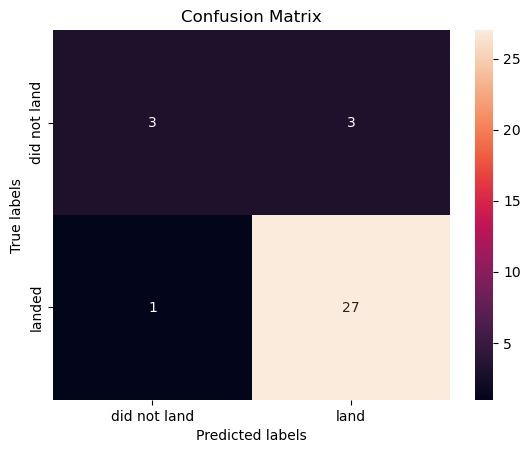

In [12]:
yhat_lr = lr_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat_lr)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the main problem is with false positives.

Now we will evaluate the model using "Area under the ROC Curve", "F1 score", and "Jaccard Index" metrics:

### ROC-AUC Score

In [13]:
yhat_lr_proba = lr_cv.predict_proba(X_test)
yhat_lr_proba[0:5]

array([[0.47677257, 0.52322743],
       [0.13740834, 0.86259166],
       [0.1014937 , 0.8985063 ],
       [0.15586548, 0.84413452],
       [0.4043709 , 0.5956291 ]])

In [14]:
lr_auc = roc_auc_score(Y_test, yhat_lr_proba[:, 1])
print("ROC-AUC score: ", lr_auc)

ROC-AUC score:  0.8928571428571429


### F1 Score

In [15]:
lr_f1 = f1_score(Y_test, yhat_lr, average='weighted') 
print("F1 score: ", lr_f1)

F1 score:  0.8726166328600404


### Jaccard Index

In [16]:
lr_jac = jaccard_score(Y_test, yhat_lr, pos_label=1)
print("Jaccard score: ", lr_jac)

Jaccard score:  0.8709677419354839


Now since we developed our logistic regression model and examined its accuracy, we can continue to develop new models with different algorithms. We will basically repeat the same process for each model and gather the accuracy metrics.

# 2. Support Vector Machine Algorithm

In [17]:
svm = SVC(probability=True)

parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'), 'C': np.logspace(-3, 3, 5), 'gamma':np.logspace(-3, 3, 5)}
svm_cv = GridSearchCV(svm, parameters, cv=10)

## Train

In [18]:
svm_cv.fit(X_train, Y_train)

print("Tuned optimum hyperparameters: ", svm_cv.best_params_)

svm_train_acc = svm_cv.best_score_
print("Accuracy in training data: ", svm_train_acc)

Tuned optimum hyperparameters:  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Accuracy in training data:  0.9181318681318682


## Evaluation

### Test

In [19]:
BestSVM = svm_cv.best_estimator_

svm_test_acc = BestSVM.score(X_test, Y_test)
print("Accuracy in test data: ", svm_test_acc)

Accuracy in test data:  0.8529411764705882


### Confusion Matrix

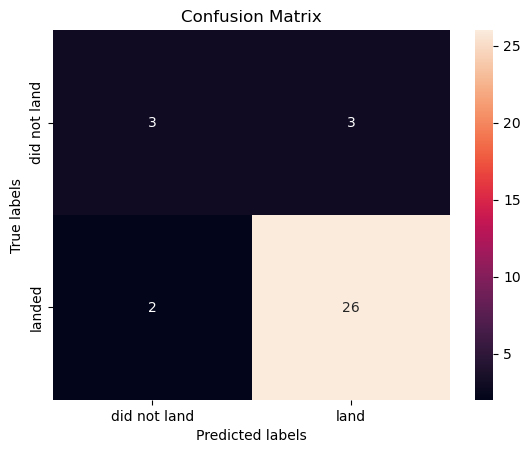

In [20]:
yhat_svm = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat_svm)

### ROC-AUC Score

In [21]:
yhat_svm_proba = svm_cv.predict_proba(X_test)

svm_auc = roc_auc_score(Y_test, yhat_svm_proba[:, 1])
print("ROC-AUC score: ", svm_auc)

ROC-AUC score:  0.9166666666666666


### F1 Score

In [22]:
svm_f1 = f1_score(Y_test, yhat_svm, average='weighted') 
print("F1 score: ", svm_f1)

F1 score:  0.8475466741720612


### Jaccard Index

In [23]:
svm_jac = jaccard_score(Y_test, yhat_svm, pos_label=1)
print("Jaccard score: ", svm_jac)

Jaccard score:  0.8387096774193549


# 3. Decision Tree Algorithm

In [24]:
tree = DecisionTreeClassifier(random_state = 25)

parameters = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [2*n for n in range(1,10)],
              'max_features': ['sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]}
tree_cv = GridSearchCV(tree, parameters, cv=10)

## Train

In [25]:
tree_cv.fit(X_train, Y_train)

print("Tuned optimum hyperparameters: ", tree_cv.best_params_)

tree_train_acc = tree_cv.best_score_
print("Accuracy in training data: ", tree_train_acc)

Tuned optimum hyperparameters:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
Accuracy in training data:  0.9252747252747253


## Evaluation

### Test

In [26]:
BestTree = tree_cv.best_estimator_

tree_test_acc = BestTree.score(X_test, Y_test)

print("Accuracy in test data: ", tree_test_acc)

Accuracy in test data:  0.9117647058823529


### Confusion Matrix

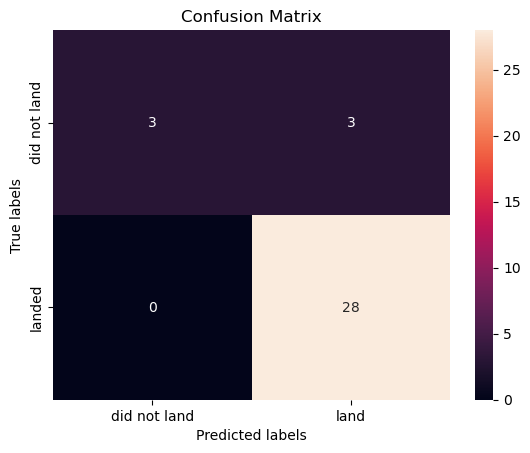

In [27]:
yhat_tree = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat_tree)

### ROC-AUC Score

In [28]:
yhat_tree_proba = tree_cv.predict_proba(X_test)

tree_auc = roc_auc_score(Y_test, yhat_tree_proba[:, 1])
print("ROC-AUC score: ", tree_auc)

ROC-AUC score:  0.9375


### F1 Score

In [29]:
tree_f1 = f1_score(Y_test, yhat_tree, average='weighted') 
print("F1 score: ", tree_f1)

F1 score:  0.8993020937188434


### Jaccard Index

In [30]:
tree_jac = jaccard_score(Y_test, yhat_tree, pos_label=1)
print("Jaccard score: ", tree_jac)

Jaccard score:  0.9032258064516129


# 4. K-Nearest Neighbors Algorithm

In [31]:
knn = KNeighborsClassifier()

parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
knn_cv = GridSearchCV(knn, parameters, cv=10)

## Train

In [32]:
knn_cv.fit(X_train, Y_train)

print("Tuned optimum hyperparameters: ", knn_cv.best_params_)

knn_train_acc = knn_cv.best_score_
print("Accuracy in training data: ", knn_train_acc)

Tuned optimum hyperparameters:  {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}
Accuracy in training data:  0.9181318681318682


## Evaluation

### Test

In [33]:
BestKNN = knn_cv.best_estimator_

knn_test_acc = BestKNN.score(X_test, Y_test)
print("Accuracy in test data: ", knn_test_acc)

Accuracy in test data:  0.9117647058823529


### Confusion Matrix

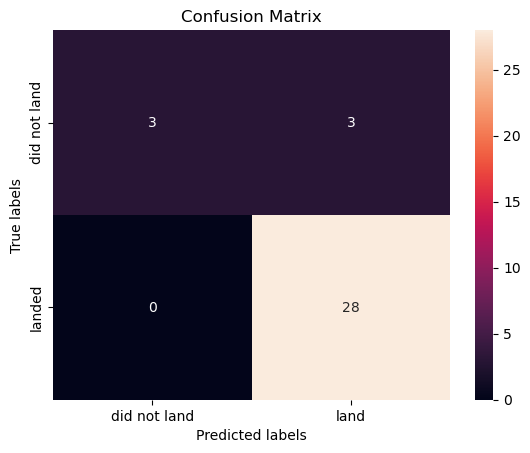

In [34]:
yhat_knn = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat_knn)

### ROC-AUC Score

In [35]:
yhat_knn_proba = knn_cv.predict_proba(X_test)

knn_auc = roc_auc_score(Y_test, yhat_knn_proba[:, 1])
print("ROC-AUC score: ", knn_auc)

ROC-AUC score:  0.7916666666666667


### F1 Score

In [36]:
knn_f1 = f1_score(Y_test, yhat_knn, average='weighted') 
print("F1 score: ", knn_f1)

F1 score:  0.8993020937188434


### Jaccard Index

In [37]:
knn_jac = jaccard_score(Y_test, yhat_knn, pos_label=1)
print("Jaccard score: ", knn_jac)

Jaccard score:  0.9032258064516129


# MODEL EVALUATION
***

Now we have gathered the metrics of our models and we will find the method that performs best:

In [38]:
metrics = {"Algorithm": ["Logistic Regression", "Support Vector Machine", "Decision Tree", "K-Nearest Neighbors"],
           #"Training Accuracy (%)": [lr_train_acc, svm_train_acc, tree_train_acc, knn_train_acc],
           "Out-of-sample Accuracy (%)": [lr_test_acc, svm_test_acc, tree_test_acc, knn_test_acc],
           "Area Under the Curve (%)": [lr_auc, svm_auc, tree_auc, knn_auc],
           "F1 Score (%)": [lr_f1, svm_f1, tree_f1, knn_f1],
           "Jaccard Index (%)": [lr_jac, svm_jac, tree_jac, knn_jac],}

scores_df = pd.DataFrame(metrics)
scores_df[["Out-of-sample Accuracy (%)", "Area Under the Curve (%)", "F1 Score (%)", "Jaccard Index (%)"]] = round(100*scores_df[["Out-of-sample Accuracy (%)", "Area Under the Curve (%)", "F1 Score (%)", "Jaccard Index (%)"]], 2)
scores_df

,Algorithm,Out-of-sample Accuracy (%),Area Under the Curve (%),F1 Score (%),Jaccard Index (%)
0,Logistic Regression,88.24,89.29,87.26,87.10
1,Support Vector Machine,85.29,91.67,84.75,83.87
2,Decision Tree,91.18,93.75,89.93,90.32
3,K-Nearest Neighbors,91.18,79.17,89.93,90.32


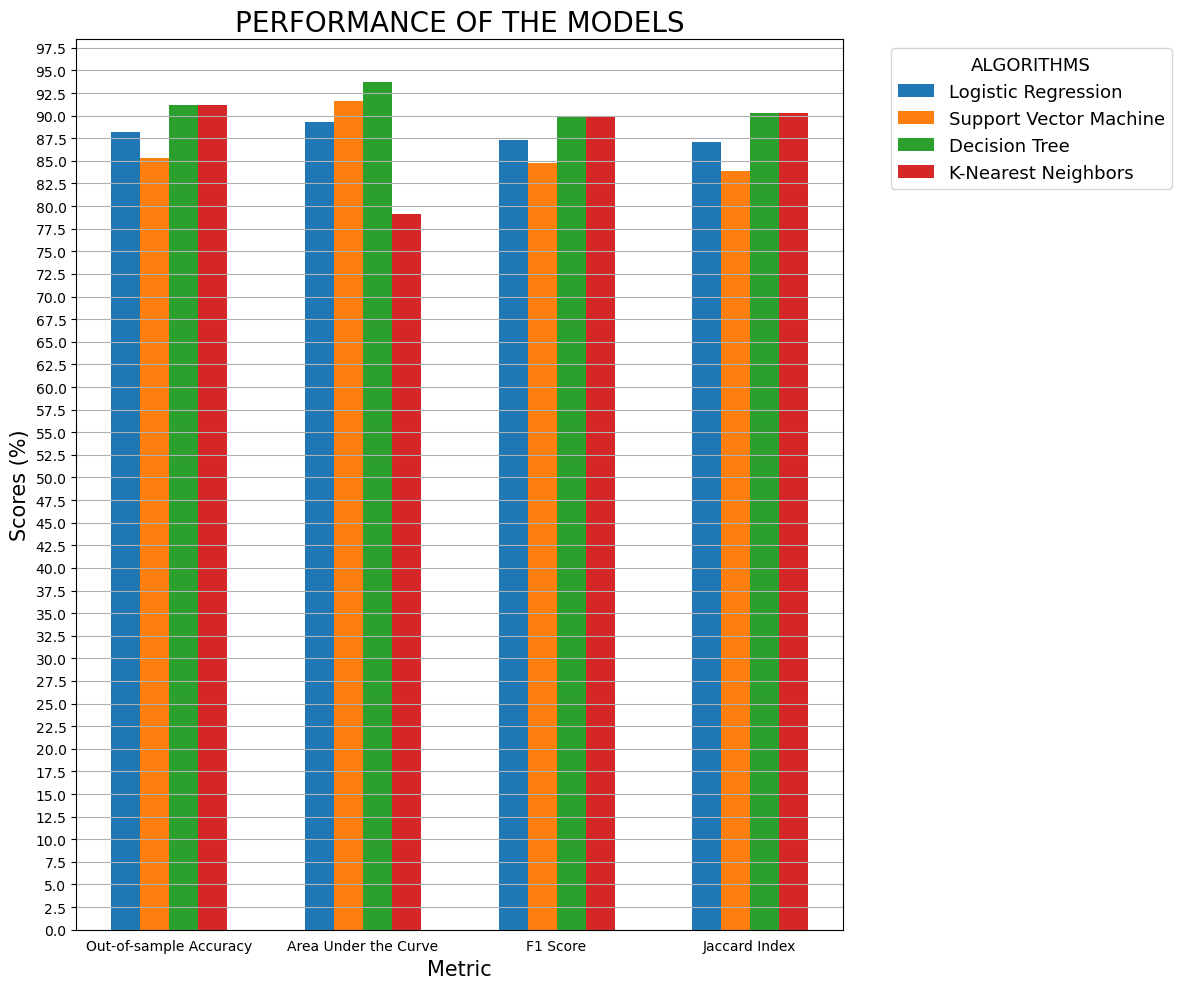

In [39]:
# Extract column names
column_names = scores_df.columns[1:]

# Extract algorithm names
algorithms = scores_df['Algorithm']

# Set up the figure and axis with larger figsize
fig, ax = plt.subplots(figsize=(12, 10))

# Set the width of the bars
bar_width = 0.15

# Set the positions of the x-axis ticks
positions = np.arange(len(column_names))

# Plot each algorithm as a separate bar
for i, algorithm in enumerate(algorithms):
    values = scores_df.loc[i, column_names]
    ax.bar(positions + i * bar_width, values, bar_width, label=algorithm)

# Remove the x-axis ticks
ax.tick_params(axis='x', which='both', bottom=False, top=False)

# Set the x-axis labels
ax.set_xticks(positions + bar_width * (len(algorithms) / 2.7))
ax.set_xticklabels([name.replace(' (%)', '') for name in column_names], rotation=0, ha='center')

# Set the y-axis label
ax.set_ylabel('Scores (%)', fontsize='15')
ax.set_xlabel('Metric', fontsize='15')

# Set the title
ax.set_title('PERFORMANCE OF THE MODELS', fontsize='20')

# Adjust legend placement and font size
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='13', title='ALGORITHMS')

# Set the title font size
legend.get_title().set_fontsize('13')


# Increase grid count on the y-axis
ax.yaxis.set_major_locator(MultipleLocator(2.5))

# Add gridlines
ax.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()

# CONCLUSION
***

From the bar plots above, we can see that the models with the highest out-of-sample accuracy, F1 score and jaccard index are Decison Tree and KNN Models. If we compare the ROC-AUC score of these two, we see that the Decision Tree model is better with the score of 93.75%. It is also shown that Decision Tree model's ROC-AUC score is highest between all of the models. So in the lights of these insights, it looks like the Decision Tree model is the best one to predict the outcome of the landing attempt of a SpaceX Falcon 9 rocket.

# <center>________________________________________________________________</center>